In [401]:
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
%matplotlib inline
sns.set()

In [402]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')
x = data['X'].flatten()
y = (np.zeros(50000)).reshape(5000, 10)
m = y.shape[0]
initialTheta = np.concatenate((weights['Theta1'].flatten(), weights['Theta2'].flatten()), axis = 0)
theta1 = initialTheta[:10025].reshape(25, 401)
theta2 = initialTheta[10025:].reshape(10, 26)

In [403]:
for number in range(0, 10):
    if number == 0:
        y[0:500, 9:] = 1
    else:
        y[number * 500:(number + 1) * 500, number - 1:number] = 1
        
y = y.flatten()

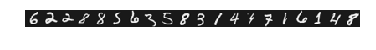

In [404]:
x = x.reshape(5000, 400)
sample = np.random.choice(x.shape[0], 20)
plt.imshow(x[sample, :].reshape(-1, 20).T, cmap='gray')
plt.axis('off');

In [405]:
def sigmoidFunction (z):
    return 1 / (1 + np.exp(-z))

In [406]:
def hypothesisFunction (theta, x):
    x = x.reshape(5000, 400)
    theta = theta.reshape(10285, 1)
    theta1, theta2 = np.split(theta, [10025])
    theta1 = theta1.reshape(25, 401)
    theta2 = theta2.reshape(10, 26)
    h = list(np.zeros((5000, 1)))
    
    for number in range(m):
        x[number] = x[number].reshape(1, 400)
        a1 = np.c_[np.ones((1, 1)), x[number].reshape(1, 400)]
        z2 = np.dot(a1, theta1.T)

        a2 = np.c_[np.ones(1), sigmoidFunction(z2)]
        z3 = np.dot(a2, theta2.T)

        a3 = sigmoidFunction(z3)
        h[number] = np.concatenate((a3.flatten(), z2.flatten(), a2.flatten(), a1.flatten()))
    return np.array(h).flatten()

In [407]:
def costFunction (theta, x, y):
    y = y.reshape(5000, 10)
    h = hypothesisFunction(theta, x).reshape(5000, 462)[:, :10]
    j = 0
    for number in range(m):
        j += (np.log(h[number].reshape(10, 1)).T.dot(-y[number].reshape(10, 1)) - np.log(1 - h[number].reshape(10, 1)).T.dot(1 - y[number].reshape(10, 1)))
    j = np.dot((1 / m), j)
    return j

In [408]:
costFunction(initialTheta, x, y)

array([[ 0.28762917]])

In [409]:
def regularizedCostFunction (theta, x, y, λ = 0.1):
    theta1, theta2 = np.split(theta, [10025])
    theta1 = theta1.reshape(25, 401)
    theta2 = theta2.reshape(10, 26)
    cost = costFunction(theta, x, y)
    cost += ((λ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))))
    return cost

In [410]:
regularizedCostFunction(initialTheta, x, y, 1)

array([[ 0.38376986]])

In [411]:
def sigmoidGradient (z):
    return sigmoidFunction(z) * (1 - sigmoidFunction(z))

In [412]:
randomTheta = np.random.rand(10285) * 2 * 0.012 - 0.012

In [413]:
def backPropagationFunction (theta, x, y):
    y = y.reshape(5000, 10)
    theta = theta.reshape(10285, 1)
    theta2 = theta[10025:].reshape(10, 26)
    h = hypothesisFunction(theta, x).reshape(5000, 462)
    a3 = h[:, :10].reshape(5000, 10)
    z2 = h[:, 10:35].reshape(5000, 25)
    a2 = h[:, 35:61].reshape(5000, 26)
    a1 = h[:, 61:].reshape(5000, 401)
    𝛿3 = a3 - y
    𝛿2 = np.dot(𝛿3, theta2[:, 1:]) * sigmoidGradient(z2)
    Δ2 = np.dot(a2.T, 𝛿3)
    Δ1 = np.dot(a1.T, 𝛿2)
    D2 = np.dot(1 / m, Δ2)
    D1 = np.dot(1 / m, Δ1)
    return np.concatenate((D1.flatten(), D2.flatten()))

In [414]:
def regularizedBackPropagationFunction (theta, x, y, λ = 0.1):
    theta1 = theta[:10025].reshape(25, 401)
    theta2 = theta[10025:].reshape(10, 26)
    
    D1 = backPropagationFunction(theta, x, y)[:10025].reshape(25, 401)
    reg1 = D1[:, 1:] + ((λ / m) * theta1[:, 1:])
    D1 = np.c_[D1[:, 1:2], reg1]
    
    D2 = backPropagationFunction(theta, x, y)[10025:].reshape(10, 26)
    reg2 = D2[:, 1:] + ((λ / m) * theta2[:, 1:])
    D2 = np.c_[D2[:, 1:2], reg2]

    return np.concatenate((D1.flatten(), D2.flatten()))